In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET

In [2]:
CATEGORIES = ["covid", "normal"]

In [3]:
dataset_path = "D:/Project2022/res/final dataset/scaled_resized/"

In [4]:
#Label
'''
0 - covid
1 - non covid

'''

'\n0 - covid\n1 - non covid\n\n'

In [35]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    raw_image = []
    concat_data = []
    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        

        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                row = img_array.sum(axis=0)
                coloumn = img_array.sum(axis=1)
                concat = np.concatenate((row, coloumn))
                raw_image.append(img_array)
                concat_data.append(concat)
                label.append(class_num)
                
            except Exception as e:
                pass
    
    df_data["raw data"] = raw_image
    df_data["concat data"] = concat_data
    df_data["label"] = label
    

    return df_data

In [36]:
dataset_df = pre_process_dataset(dataset_path)

Loading dataset: class covid



Loading dataset: class normal


In [37]:
dataset_df.head(-1)

,raw data,concat data,label
0,"[[196, 203, 211, 216, 220, 209, 195, 199, 212,...","[130269, 130275, 119681, 94143, 91801, 90830, ...",0
1,"[[236, 240, 243, 245, 243, 239, 235, 230, 228,...","[96992, 95913, 94552, 93205, 92552, 92118, 917...",0
2,"[[81, 82, 82, 82, 82, 82, 82, 83, 83, 83, 81, ...","[40643, 40295, 39912, 39606, 39258, 38974, 387...",0
3,"[[71, 73, 73, 70, 71, 74, 79, 82, 85, 87, 86, ...","[31131, 31049, 30961, 30869, 30609, 30270, 299...",0
4,"[[74, 75, 75, 73, 70, 70, 73, 79, 84, 87, 87, ...","[32192, 32296, 32368, 32338, 31947, 31603, 313...",0
...,...,...,...
14036,"[[88, 87, 86, 85, 86, 86, 86, 87, 87, 88, 88, ...","[78324, 78944, 79477, 79581, 79455, 79365, 793...",1
14037,"[[80, 79, 79, 79, 79, 79, 79, 78, 77, 76, 75, ...","[78313, 77976, 77727, 77706, 77569, 77379, 771...",1
14038,"[[80, 80, 80, 80, 79, 81, 84, 91, 103, 119, 13...","[79858, 80032, 80305, 80668, 80814, 80970, 810...",1
14039,"[[79, 79, 79, 81, 82, 88, 97, 112, 126, 137, 1...","[78543, 79192, 80004, 80721, 80904, 80942, 807...",1


In [38]:
dataset_df["label"].value_counts()

0    7149
1    6893
Name: label, dtype: int64

In [39]:
dataset = dataset_df["concat data"].values
X = []
for img in dataset:
    X.append(img.tolist())
X = np.array(X)
y = np.array(dataset_df["label"].values)
print("X shape", X.shape)
print("y shape", y.shape)


X shape (14042, 1024)
y shape (14042,)


In [40]:
from sklearn import preprocessing
X_norm = preprocessing.normalize(X)

In [43]:
# change dimensions for training 
dataset_X = np.expand_dims(X_norm, axis=-1)
dataset_y = np.expand_dims(y, axis=-1)
print(" shape of the dataset after changing the dimension")
print("X : ", dataset_X.shape)
print("y : ", dataset_y.shape)

 shape of the dataset after changing the dimension
X :  (14042, 1024, 1)
y :  (14042, 1)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, shuffle=True, test_size=0.20, random_state=0)

In [45]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1024, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
history = model.fit(X_train, y_train,10,5)

Epoch 1/5
1124/1124 [==============================] - 31s 27ms/step - loss: 0.5884 - accuracy: 0.6940
Epoch 2/5
1124/1124 [==============================] - 31s 27ms/step - loss: 0.4756 - accuracy: 0.7754
Epoch 3/5
1124/1124 [==============================] - 31s 28ms/step - loss: 0.4163 - accuracy: 0.8112
Epoch 4/5
1124/1124 [==============================] - 31s 27ms/step - loss: 0.3961 - accuracy: 0.8204
Epoch 5/5
1124/1124 [==============================] - 31s 28ms/step - loss: 0.3804 - accuracy: 0.8276


In [47]:
model.save("D:/Project2022/models/scaled_resized.h5")

In [48]:
# test loss, test accuracy
accuracy = model.evaluate(X_test, y_test, batch_size=100, verbose=0)

In [49]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.8465645909309387
Test loss 0.3973102271556854


In [50]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [51]:
from sklearn.metrics import classification_report 
print(classification_report(y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.89      0.79      0.84      1395
      Normal       0.81      0.90      0.86      1414

    accuracy                           0.85      2809
   macro avg       0.85      0.85      0.85      2809
weighted avg       0.85      0.85      0.85      2809



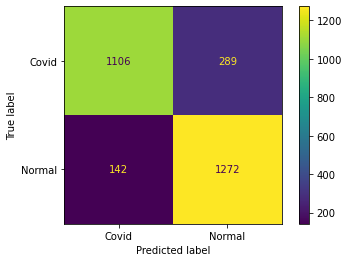

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
